In [33]:
from datetime import datetime
from dateutil import parser

import pandas as pd
spotify_1mil = pd.read_csv('tracks_features.csv')

def parse_datetime(date_string):
    formats = ["%Y-%m-%d", "%Y", "%m/%d/%Y", "%m-%d-%Y", "%Y-%m-%d", "%Y/%m/%d", "%m/%d/%Y", "%m-%d-%Y"]
    for fmt in formats:
        try:
            return datetime.strptime(date_string, fmt)
        except ValueError:
            print(date_string)

def parse_datetime2(date_string):
    try:
        return pd.to_datetime(date_string)
    except ValueError:
        print(date_string)

spotify_1mil.release_date = spotify_1mil.release_date.apply(lambda x: parse_datetime2(x))

0000
0000
0000
0000
0000
0000
0000
0000
0000
0000


In [36]:
print(spotify_1mil.release_date.max())
print(spotify_1mil.release_date.min())

2020-12-18 00:00:00
1900-01-01 00:00:00


## TRAINING MODEL

In [97]:
modeling_data = pd.read_csv('./grammy_dashboard/data/modeling_data.csv')

test_data = pd.read_csv('./grammy_dashboard/data/testing_data.csv').rename(columns = {'is_explicit': 'explicit'})

for col in ['charted_q1', 'charted_q2', 'charted_q3', 'charted_q4', 'explicit']:
    modeling_data[col] = modeling_data[col].map({True: 1, False: 0})
    test_data[col] = test_data[col].map({True: 1, False: 0})

In [96]:
print(modeling_data.columns)
print(test_data.columns)

Index(['artist', 'song', 'won_grammy', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'duration_sec', 'weeks_on_chart', 'peak_position', 'started_charting',
       'charted_q1', 'charted_q2', 'charted_q3', 'charted_q4'],
      dtype='object')
Index(['song', 'artist', 'explicit', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature', 'duration_sec',
       'weeks_on_chart', 'peak_position', 'started_charting', 'charted_q1',
       'charted_q2', 'charted_q3', 'charted_q4'],
      dtype='object')


In [98]:
X = modeling_data.drop(columns = ['won_grammy', 'artist', 'song', 'started_charting'])
y = modeling_data.won_grammy.map({'Yes': 1, 'No': 0})

X_test = test_data.drop(columns = ['artist', 'song', 'started_charting'])

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

for col in categorical_cols:
    X[col] = X[col].astype('category')
    test_data[col] = test_data[col].astype('category')

y.value_counts()

won_grammy
0    7547
1      61
Name: count, dtype: int64

In [82]:
from xgboost import XGBClassifier
from skopt.space import Real, Integer
from skopt import BayesSearchCV
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'gamma': trial.suggest_float('gamma', 0, 0.2),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
    }

    base = XGBClassifier(**params, scale_pos_weight = 5149/61, enable_categorical = True, random_state = 40)


    cv_scores = cross_val_score(base, X, y, cv = 5, scoring = 'precision')

    return cv_scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials = 75)

[I 2025-06-01 22:47:45,394] A new study created in memory with name: no-name-73db5a04-c4b0-44e2-8a62-97b2833ce420
[I 2025-06-01 22:47:48,803] Trial 0 finished with value: 0.14754689754689754 and parameters: {'n_estimators': 463, 'learning_rate': 0.07889043775950387, 'max_depth': 11, 'min_child_weight': 4, 'gamma': 0.15401595790485703, 'subsample': 0.9150081766932656, 'colsample_bytree': 0.9577999140932489, 'reg_alpha': 0.8190864705321865, 'reg_lambda': 1.2135064597112832}. Best is trial 0 with value: 0.14754689754689754.
[I 2025-06-01 22:47:50,901] Trial 1 finished with value: 0.17959276018099546 and parameters: {'n_estimators': 497, 'learning_rate': 0.3157392136953174, 'max_depth': 11, 'min_child_weight': 4, 'gamma': 0.03780059109059857, 'subsample': 0.8760383753529126, 'colsample_bytree': 0.7290222062326803, 'reg_alpha': 8.55049186263745, 'reg_lambda': 8.983596959612921}. Best is trial 1 with value: 0.17959276018099546.
[I 2025-06-01 22:47:53,496] Trial 2 finished with value: 0.14820

In [113]:
# Generate Prediction

model = XGBClassifier(**study.best_params, scale_pos_weight = 5149/61, enable_categorical = True, random_state = 40).fit(X, y)

threshold = 0.8
train_prediction = model.predict_proba(X)
prediction = model.predict_proba(X_test)


csv_pred = pd.DataFrame({'Grammy_Prob': prediction[:,1]}, index = test_data['song'])
display(csv_pred.head(5))

# Metrics

from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, f1_score

print('------------------ Metrics ------------------')
print('best parameters:', study.best_params)

def metrics(prediction, actual, threshold):

    bi_prediction = (prediction >= threshold).astype(int)[:,1]
    print('Recall:', recall_score(actual, bi_prediction))
    print('ROC/AUC:', roc_auc_score(actual, bi_prediction))
    print('accuracy:', accuracy_score(actual, bi_prediction))
    print('F1:', f1_score(actual, bi_prediction))

    confusion_mat = confusion_matrix(actual, bi_prediction)
    labels = ['Actual Negative', 'Actual Positive']
    formatted_confusion_mat = pd.DataFrame(confusion_mat, index=labels, columns=[f'Predicted {label}' for label in labels])
    print('\n-------------- Confusion Matrix --------------')
    display(formatted_confusion_mat)

metrics(train_prediction, y, threshold)

,Grammy_Prob
song,
Fortnight (feat. Post Malone),0.348324
Espresso,0.004534
i like the way you kiss me,0.001310
Too Sweet,0.627013
I Can Do It With a Broken Heart,0.000018


------------------ Metrics ------------------
best parameters: {'n_estimators': 467, 'learning_rate': 0.4763626558163035, 'max_depth': 11, 'min_child_weight': 1, 'gamma': 0.01814517497628288, 'subsample': 0.5744955051697921, 'colsample_bytree': 0.6965067833039388, 'reg_alpha': 4.198734464173267, 'reg_lambda': 7.048209305296713}
Recall: 1.0
ROC/AUC: 0.9999337485093415
accuracy: 0.9998685594111462
F1: 0.991869918699187

-------------- Confusion Matrix --------------


,Predicted Actual Negative,Predicted Actual Positive
Actual Negative,7546,1
Actual Positive,0,61


<Axes: xlabel='Importance', ylabel='Feature'>

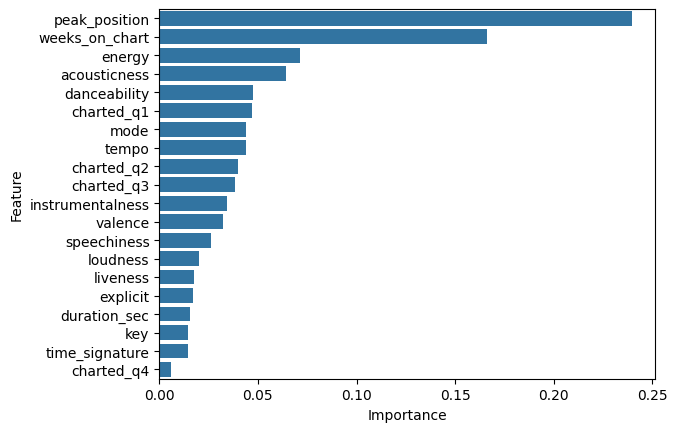

In [129]:
import seaborn as sns

importances  = model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': pd.DataFrame(X).columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

sns.barplot(feature_importance_df, x = 'Importance', y = 'Feature')